In [1]:
import pandas as pd
import numpy as np
import json
from scipy.stats import wasserstein_distance

import ast
import math
import re

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
country_code_list = [20, 32, 51, 36, 50, 68, 76, 124, 152, 156, 170, 196, 203, 276, 218, 818, 231, 826, 300, 320, 344, 360, 356, 364, 368, 400, 392, 398, 404, 417, 410, 422, 434, 446, 504, 462, 484, 104, 496, 458, 566, 558, 909, 528, 554, 586, 604, 608, 630, 642, 643, 702, 688, 703, 764, 762, 788, 792, 158, 804, 858, 840, 860, 862, 704, 716]

In [3]:
len(country_code_list)

66

In [4]:
llm_list = [
    "CohereLabs/aya-23-35B",
    "meta-llama/Meta-Llama-3-70B-Instruct",
    "Qwen/Qwen2.5-72B-Instruct",
    "gpt-3.5-turbo", 
    "gpt-4", 
    "deepseek-chat",
    "deepseek-reasoner"
]

llm_name_dict = {
    "CohereLabs/aya-23-35B": "Aya23",
    "meta-llama/Meta-Llama-3-70B-Instruct": "Llama3",
    "Qwen/Qwen2.5-72B-Instruct": "Qwen2.5",
    "gpt-3.5-turbo": "GPT-3.5", 
    "gpt-4": "GPT-4", 
    "deepseek-chat": "DS-V3",
    "deepseek-reasoner": "DS-R1"
}

In [7]:
def get_question_dict():
    question_dict= dict()
    lm_data_path = "../../results/RQ1/gpt-4/results.csv"
    lm_df = pd.read_csv(lm_data_path)
    lm_df = lm_df[lm_df['type'] == 'Opinion-Dependent']
    for _, row in lm_df.iterrows():
        question_dict[row['id']] = ast.literal_eval(row['choice_keys'])
    return question_dict

question_dict = get_question_dict()
len(question_dict)

144

In [8]:
human_data_path = "../../dataset/wvs/WV7.csv"
human_df = pd.read_csv(human_data_path, low_memory=False)

In [9]:
def get_human_distribution_by_question(question_item, human_df):
    human_df = human_df[question_item[0]]
    if human_df.empty:
        return None
    
    human_df = human_df.value_counts().sort_index()

    human_distribution = {}
    is_ok = False
    for c in question_item[1]:
        if int(c) not in human_df.index:
            human_distribution[c] = 0
        else:
            human_distribution[c] = human_df[int(c)]
            is_ok = True
    if not is_ok:
        return None
    human_distribution = {k: float(v / sum(human_distribution.values())) for k, v in human_distribution.items()}
    return human_distribution


In [10]:
human_od_dict = dict()
for (question_item) in question_dict.items():
    human_distribution = get_human_distribution_by_question(question_item, human_df)
    if human_distribution is None:
        continue
    human_od_dict[question_item[0]] = human_distribution

In [11]:
def get_llm_distribution_by_country_and_question(question_item, llm_df):
    llm_distribution_rough = llm_df[llm_df['id'] == question_item[0]]['response'].values[0]
    try:
        prob_dict = ast.literal_eval(llm_distribution_rough)
    except:
        llm_distribution_rough = re.sub(r'(\d+):\s*([\d.]+%)', r"'\1': '\2'", llm_distribution_rough)
        prob_dict = ast.literal_eval(llm_distribution_rough)

    llm_distribution = {k: float(v.strip('%')) / 100 for k, v in prob_dict.items()}
    return llm_distribution

In [12]:
def get_human_distribution_by_country_and_question(country_code, question_item, human_df):
    human_df = human_df[human_df['B_COUNTRY'] == int(country_code)][question_item[0]]
    if human_df.empty:
        return None
    
    human_df = human_df.value_counts().sort_index()

    human_distribution = {}
    is_ok = False
    for c in question_item[1]:
        if int(c) not in human_df.index:
            human_distribution[c] = 0
        else:
            human_distribution[c] = human_df[int(c)]
            is_ok = True
    if not is_ok:
        return None
    human_distribution = {k: float(v / sum(human_distribution.values())) for k, v in human_distribution.items()}
    return human_distribution

In [ ]:
def alignment_score(D1, D2, Q):
    scores = []
    for q in Q:
        if q not in D1 or q not in D2:
            continue
        
        p1 = D1[q]
        p2 = D2[q]

        if len(p1) != len(p2):
            continue
        N = len(p1) 
        support = np.array([int(k) for k, v in sorted(p1.items())])
        wd = wasserstein_distance(support, support, [v for k, v in sorted(p1.items())], [v for k, v in sorted(p2.items())])
        score = 1 - wd / (N - 1)
        scores.append(score)
    return np.round(np.mean(scores), 4)

In [14]:
llm_data_list = []
for llm in llm_list:
    llm_data_path = f"../../results/RQ1/{llm}/results.csv"
    llm_df = pd.read_csv(llm_data_path)
    llm_df = llm_df[llm_df['type'] == 'Opinion-Dependent']
    llm_od_dict = dict()
    for (question_item) in question_dict.items():
        if question_item[0] in ["Q60", "Q70", "Q90", "Q110", "Q130"]:
            continue
        llm_distribution = get_llm_distribution_by_country_and_question(question_item, llm_df)
        if llm_distribution is None:
            continue
        llm_od_dict[question_item[0]] = llm_distribution

    country_score_list = []
    for country_code in country_code_list:
        country_od_dict = dict()
        for (question_item) in question_dict.items():
            llm_distribution = get_human_distribution_by_country_and_question(country_code,question_item, human_df)
            if llm_distribution is None:
                continue
            country_od_dict[question_item[0]] = llm_distribution
        if len(country_od_dict) == 0:
            continue
        score = alignment_score(llm_od_dict, country_od_dict, question_dict.keys())
        llm_data_list.append([llm_name_dict[llm], np.round(score, 4)])

In [15]:
llms_df = pd.DataFrame(llm_data_list, columns=['llm', 'score'])
_group_means = llms_df.groupby('llm')['score'].mean()
group_means = {}
for llm_name in llm_name_dict.values():
    group_means[llm_name] = _group_means[llm_name]

/home/yangliu/anaconda3/envs/l/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 6.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/yangliu/anaconda3/envs/l/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 9.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/yangliu/anaconda3/envs/l/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 9.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


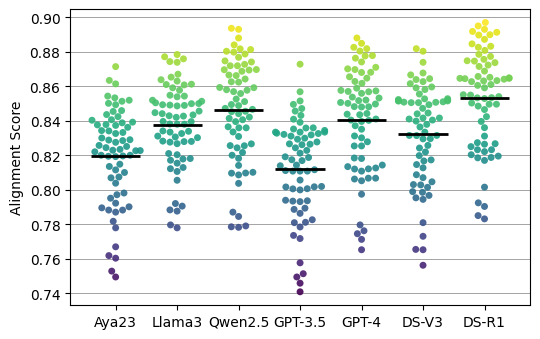

In [20]:
plt.figure(figsize=(5.5, 3.5))
ax = sns.swarmplot(
    x="llm", 
    y="score", 
    data=llms_df, 
    hue="score",
    legend=False,
    alpha=0.9, 
    palette="viridis", 
    zorder=8,
    linewidth=0.0,
    size=5)
for i, (llm, mean) in enumerate(group_means.items()):
    ax.hlines(mean, i - 0.4, i + 0.4, color='k', lw=2, zorder=10)
plt.xlabel("")
plt.ylabel("Alignment Score")
plt.grid(axis='y',color='grey', linewidth=0.5)
plt.tight_layout()
plt.savefig("../../figures/RQ1/compare_llms.pdf",dpi=300)